In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357281 sha256=356516c2480e5a72ab9601a8112c9a789e08bda2514ecb9cda5b87627e444d77
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import time

In [619]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from surprise import Dataset
from surprise import Reader

In [ ]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error

In [ ]:
def mse(y: list, yhat: np.array) -> float:
    mse = mean_squared_error(y, yhat)
    return mse

def rmse(y: list, yhat: np.array) -> float:
    rmse = sqrt(mean_squared_error(y, yhat))
    return rmse

In [ ]:
# загрузим датасет со своего Google Drive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
books = pd.read_csv('drive/MyDrive/Netology/Books.csv')
ratings = pd.read_csv('drive/MyDrive/Netology/Ratings.csv')

In [ ]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
books_with_ratings = books.merge(ratings, on='ISBN').reset_index(drop=True)
books_with_ratings.dropna(inplace=True)

In [ ]:
df = books_with_ratings[['ISBN','Book-Title', 'Book-Author', 'User-ID', 'Book-Rating']]
df.rename(columns={'ISBN':'isbn','Book-Title': 'title','Book-Author': 'author', 'User-ID': 'user','Book-Rating':'rating'}, inplace=True)

In [ ]:
df.head()

,isbn,title,author,user,rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,8,5
2,0002005018,Clara Callan,Richard Bruce Wright,11400,0
3,0002005018,Clara Callan,Richard Bruce Wright,11676,8
4,0002005018,Clara Callan,Richard Bruce Wright,41385,0


In [ ]:
#изучим датасет и преобразуем его для дальнейшего использования

In [ ]:
df.info() #пропусков нет

<class 'pandas.core.frame.DataFrame'>
Index: 1031128 entries, 0 to 1031135
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   isbn    1031128 non-null  object
 1   title   1031128 non-null  object
 2   author  1031128 non-null  object
 3   user    1031128 non-null  int64 
 4   rating  1031128 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 47.2+ MB


In [ ]:
df['rating'].value_counts()

,count
rating,
0,647291
8,91803
10,71224
7,66401
9,60776
5,45355
6,31687
4,7617
3,5118


In [ ]:
#уберем все оценки = 0

In [ ]:
df1 = df[df['rating'] != 0]

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 383837 entries, 1 to 1031132
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   isbn    383837 non-null  object
 1   title   383837 non-null  object
 2   author  383837 non-null  object
 3   user    383837 non-null  int64 
 4   rating  383837 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 17.6+ MB


In [ ]:
df1['user'].nunique() #пользователи, которые проставили оценки

68091

In [ ]:
df1['isbn'].nunique() #книги, которым проставили оценки

149831

In [ ]:
df1['title'].nunique() #книги, которым проставили оценки

135563

In [ ]:
# в зависимости от издательства одна и та же книга будет иметь разный isbn.
# тк пользователю не важно издательство, то введем новый столбец book_id, который заменит существующий isbn и будет одинаковый для одноименных книг

In [ ]:
df1['combined'] = df1[['title','author']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [ ]:
df1.head()

,isbn,title,author,user,rating,combined
1,0002005018,Clara Callan,Richard Bruce Wright,8,5,Clara Callan_Richard Bruce Wright
3,0002005018,Clara Callan,Richard Bruce Wright,11676,8,Clara Callan_Richard Bruce Wright
5,0002005018,Clara Callan,Richard Bruce Wright,67544,8,Clara Callan_Richard Bruce Wright
8,0002005018,Clara Callan,Richard Bruce Wright,116866,9,Clara Callan_Richard Bruce Wright
9,0002005018,Clara Callan,Richard Bruce Wright,123629,9,Clara Callan_Richard Bruce Wright


In [ ]:
df1['combined'].nunique() #уникальные значение книга-автор

139637

In [ ]:
#используем label-encoding

In [ ]:
lf = LabelEncoder()
df1['book_id'] = lf.fit_transform(df1['combined'])
df1['user_id'] = lf.fit_transform(df1['user'])

In [ ]:
df1.head()

,isbn,title,author,user,rating,combined,book_id,user_id
1,0002005018,Clara Callan,Richard Bruce Wright,8,5,Clara Callan_Richard Bruce Wright,20978,0
3,0002005018,Clara Callan,Richard Bruce Wright,11676,8,Clara Callan_Richard Bruce Wright,20978,2719
5,0002005018,Clara Callan,Richard Bruce Wright,67544,8,Clara Callan_Richard Bruce Wright,20978,16635
8,0002005018,Clara Callan,Richard Bruce Wright,116866,9,Clara Callan_Richard Bruce Wright,20978,28663
9,0002005018,Clara Callan,Richard Bruce Wright,123629,9,Clara Callan_Richard Bruce Wright,20978,30293


In [ ]:
#проверим сохранились ли все данные: должно быть 68091 пользователей и 139637 книг
print('книги:', df1['book_id'].nunique())
print('пользователи', df1['user_id'].nunique())

книги: 139637
пользователи 68091


In [ ]:
df3 = df1[['book_id', 'title', 'author']]
df3 = df3.drop_duplicates('book_id')#book_id-title-autor
df3

,book_id,title,author
1,20978,Clara Callan,Richard Bruce Wright
16,27540,Decision in Normandy,Carlo D'Este
19,39898,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
31,112141,The Kitchen God's Wife,Amy Tan
64,134424,What If?: The World's Foremost Military Histor...,Robert Cowley
...,...,...,...
1031116,136057,Wicca. Eine EinfÃ?Â¼hrung in weiÃ?Â?e Magie.,Scott Cunningham
1031117,33767,"Ein Fall fÃ?Â¼r TKKG, Bd.50, Sklaven fÃ?Â¼r Wu...",Stefan Wolf
1031128,21417,Cocktail Classics,David Biggs
1031130,39606,Flashpoints: Promise and Peril in a New World,Robin Wright


In [ ]:
# посчитаем средний рейтинг книг
avg_rating = df1.groupby(['book_id','title', 'author'])['rating'].mean().reset_index()
avg_rating.rename(columns={'rating': 'avg_rating'}, inplace=True)

In [ ]:
avg_rating.sort_values('avg_rating', ascending=False)

,book_id,title,author,avg_rating
69818,69818,Miracle of Colour Healing: Aura-Soma Therapy a...,Vicky Wall,10.0
19118,19118,Celtic Designs CD-ROM and Book (Dover Electron...,Dover,10.0
19133,19133,Celtic Needlepoint,Alice Starmore,10.0
79417,79417,"Parler suisse, parler franÃ§ais: Guide pratiqu...",Georges ArÃ¨s,10.0
19129,19129,Celtic Myth and Legend,Charles Squire,10.0
...,...,...,...,...
68272,68272,Measure of a Woman,Gene A. Getz,1.0
123092,123092,The Vampyre of Moura (Moura Series),Virginia Coffman,1.0
53853,53853,Interest of Justice (OME),Rosenberg Nancy Taylor,1.0
70969,70969,More Great Ghost Stories,John Canning,1.0


In [ ]:
#посчитем количество оценок по книге
book_ratings_count = df1.groupby(['book_id'])['rating'].count().reset_index()
book_ratings_count.rename(columns={'rating': 'num_rating'}, inplace=True)

In [ ]:
book_ratings_count.sort_values('num_rating', ascending=False)

,book_id,num_rating
113590,113590,707
136224,136224,581
105804,105804,488
119737,119737,406
115342,115342,393
...,...,...
56034,56034,1
56033,56033,1
56032,56032,1
56031,56031,1


In [ ]:
#соединим обе таблицы
popular_df = avg_rating.merge(book_ratings_count, on='book_id').reset_index(drop=True)

In [ ]:
popular_df.head()

,book_id,title,author,avg_rating,num_rating
0,0,A Light in the Storm: The Civil War Diary of ...,Karen Hesse,9.000000,1
1,1,"Ask Lily (Young Women of Faith: Lily Series, ...",Nancy N. Rue,8.000000,1
2,2,Dark Justice,Jack Higgins,10.000000,1
3,3,Earth Prayers From around the World: 365 Pray...,Elizabeth Roberts,7.142857,7
4,4,Final Fantasy Anthology: Official Strategy Gu...,David Cassady,10.000000,2


In [ ]:
# топ 10 книг по рейтингу и по количеству оценок (когда это первый приход пользователя)
popular_df.sort_values(['avg_rating', 'num_rating'], ascending=False).head(10)

,book_id,title,author,avg_rating,num_rating
82106,82106,Postmarked Yesteryear: 30 Rare Holiday Postcards,Pamela E. Apkarian-Russell,10.0,11
120613,120613,The Sneetches and Other Stories,Dr. Seuss,10.0,8
73728,73728,Natural California: A Postcard Book,Not Applicable (Na ),10.0,7
130346,130346,Uncle John's Supremely Satisfying Bathroom Rea...,Bathroom Readers Institute,10.0,7
76669,76669,"Oh, the Thinks You Can Think! (I Can Read It A...",Dr. Seuss,10.0,6
92970,92970,Six by Seuss: A Treasury of Dr. Seuss Classics,Seuss,10.0,6
113412,113412,The Lord of the Rings (Leatherette Collector's...,J. R. R. Tolkien,10.0,6
3336,3336,A Prayer for America,Dennis J. Kucinich,10.0,5
4313,4313,A Voice in the Wind (Mark of the Lion #1),Francine Rivers,10.0,5
16939,16939,Bury Me With Soldiers: One Grunt's Honest Stor...,C. W. Standiford,10.0,5


In [ ]:
#рекомендация по автору

In [ ]:
def rec_by_author(author,k):
   author = popular_df[popular_df['author'] == author].sort_values(['avg_rating'], ascending=False).reset_index().head(k)
   return author[['book_id', 'title']]

In [ ]:
rec_by_author('Stephen King',10)

,book_id,title
0,139621,Ã?Â?a
1,11340,Bad Death of Eduard Delacroix (Green Mile S.)
2,109875,The Green Mile : The Complete Serial Novel
3,105884,The Dark Half (G.K. Hall Large Print Book Series)
4,28282,Der Talisman
5,30219,Differentes saisons
6,89485,Schwarz. Der dunkle Turm.
7,84046,"Quitters, Inc."
8,74700,Night Journey (Green Mile S.)
9,60477,"Le FlÃ?Â©au, tome 1"


In [ ]:
rec_by_author('J. R. R. Tolkien',10)

,book_id,title
0,4140,A Tolkien Miscellany
1,122680,The Two Towers (Lord of the Rings (Hardcover))
2,113412,The Lord of the Rings (Leatherette Collector's...
3,111636,The J. R. R. Tolkien Audio Collection
4,110645,The Hobbit (Illustrated Edition)
5,9231,Arbol y Hoja - Tapa Dura -
6,110654,"The Hobbit: Or, There and Back Again"
7,108123,The Fellowship of the Ring: Being the First Pa...
8,34363,El Senor De Los Anillos/the Lord of the Rings
9,29991,Die Zwei Turme II


In [ ]:
#рекомендация по прочитанной книге

In [ ]:
# чтобы получилось обработать данные (хватило ОЗУ), уменьшим датасет по следующим параметрам:
# пользователь должен поставить не менее 10 оценок
# книга должна иметь не менее 10 оценок
# рейтинг книги должен быть не мненее 5

In [ ]:
rating_5 = df1[df1['rating'] >= 5]

In [ ]:
book_rating_count = rating_5.groupby('book_id')['rating'].count()
books_10 = book_rating_count[book_rating_count > 10].index
df2 = rating_5[rating_5['book_id'].isin(books_10)]

In [ ]:
user_rating_count = df2.groupby('user_id')['rating'].count()
users_10 = user_rating_count[user_rating_count > 10].index
df2_ = df2[df2['user_id'].isin(users_10)]

In [ ]:
len(df2_)

67641

In [ ]:
df2_ = df2_[['book_id', 'title', 'author','user_id', 'rating']]

In [ ]:
df2_.shape

(67641, 5)

In [ ]:
df2_['book_id'] = lf.fit_transform(df2_['book_id'])
df2_['user_id'] = lf.fit_transform(df2_['user_id'])
df2_['new_rating'] = lf.fit_transform(df2_['rating'])

In [ ]:
df2_.head()

,book_id,title,author,user_id,rating,new_rating
31,3731,The Kitchen God's Wife,Amy Tan,89,9,4
32,3731,The Kitchen God's Wife,Amy Tan,220,9,4
34,3731,The Kitchen God's Wife,Amy Tan,368,9,4
42,3731,The Kitchen God's Wife,Amy Tan,1283,10,5
54,3731,The Kitchen God's Wife,Amy Tan,1984,7,2


In [ ]:
df2_['book_id'].nunique()  #книги

4690

In [ ]:
df2_['user_id'].nunique() #пользователи

2380

In [ ]:
df2_[df2_['title'] == 'The Hobbit']

,book_id,title,author,user_id,rating,new_rating
130783,3666,The Hobbit,J. R. R. Tolkien,382,7,2
130788,3666,The Hobbit,J. R. R. Tolkien,648,10,5
130790,3666,The Hobbit,J. R. R. Tolkien,1103,8,3
130793,3666,The Hobbit,J. R. R. Tolkien,1398,10,5
130794,3666,The Hobbit,J. R. R. Tolkien,1693,9,4
130798,3666,The Hobbit,J. R. R. Tolkien,2101,9,4
130799,3666,The Hobbit,J. R. R. Tolkien,2178,9,4
511295,3666,The Hobbit,J. R. R. Tolkien,170,10,5
511298,3666,The Hobbit,J. R. R. Tolkien,705,10,5
511299,3666,The Hobbit,J. R. R. Tolkien,1874,10,5


In [ ]:
df2_[df2_['user_id'] == 648]

,book_id,title,author,user_id,rating,new_rating
27172,1055,Dragonsong (Harper Hall Trilogy),Anne McCaffrey,648,10,5
27217,743,Cloud Nine,Luanne Rice,648,10,5
39142,4587,Who Moved My Cheese? An Amazing Way to Deal wi...,Spencer Johnson,648,9,4
62565,1051,Dragonsdawn,Anne McCaffrey,648,10,5
62629,304,Anne Frank: The Diary of a Young Girl,ANNE FRANK,648,10,5
...,...,...,...,...,...,...
638994,2815,Scarlet Letter,Nathaniel Hawthorne,648,10,5
738654,1425,"God Emperor of Dune (Dune Chronicles, Book 4)",Frank Herbert,648,9,4
831843,1079,"Dune Messiah (Dune Chronicles, Book 2)",Frank Herbert,648,9,4
855240,3995,"The Return of the King (The Lord of the Rings,...",J. R. R. Tolkien,648,10,5


In [ ]:
df2_['rat_for_svd'] = df2_['new_rating'] + 1
df2_.head()

,book_id,title,author,user_id,rating,new_rating,rat_for_svd
31,3731,The Kitchen God's Wife,Amy Tan,89,9,4,5
32,3731,The Kitchen God's Wife,Amy Tan,220,9,4,5
34,3731,The Kitchen God's Wife,Amy Tan,368,9,4,5
42,3731,The Kitchen God's Wife,Amy Tan,1283,10,5,6
54,3731,The Kitchen God's Wife,Amy Tan,1984,7,2,3


In [ ]:
dataset = pd.DataFrame({
    'uid': df2_['user_id'],
    'iid': df2_['book_id'],
    'rating': df2_['rat_for_svd']})

In [ ]:
len(dataset)

67641

In [ ]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(dataset, reader)

In [ ]:
trainset = data.build_full_trainset()

In [ ]:
from surprise import KNNBasic

In [ ]:
sim_options = { "name": "cosine",
                "user_based": False,  # сходство между книгами
                }

In [ ]:
model_item = KNNBasic(k = 10, sim_options = sim_options)

In [ ]:
model_item.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
def rec_by_book(book_id):
    item_inner_id = model_item.trainset.to_inner_iid(book_id)
    neighbors = model_item.get_neighbors(item_inner_id, k=10)

    rec_book_ids = [model_item.trainset.to_raw_iid(inner_id) for inner_id in neighbors]

    return rec_book_ids

In [ ]:
#печать списка книг с названием
def books_to_read(rec_list):
    rec_books = []
    for id in rec_list:
      title = df2_.loc[df2_['book_id'] == id, 'title'].values
      rec_books.append((id , title[0]))
      rec_books_df = pd.DataFrame(rec_books, columns = ['book_id', 'title'])
    return rec_books_df

In [ ]:
rec_by_book(3666) #The Hobbit

[3731, 4149, 435, 4339, 4137, 3370, 3930, 3562, 286, 2815]

In [ ]:
books_to_read(rec_by_book(3666))

,book_id,title
0,3731,The Kitchen God's Wife
1,4149,The Testament
2,435,Beloved (Plume Contemporary Fiction)
3,4339,To Kill a Mockingbird
4,4137,The Tao of Pooh
5,3370,The Catcher in the Rye
6,3930,The Pillars of the Earth
7,3562,The Five People You Meet in Heaven
8,286,Angels &amp; Demons
9,2815,Scarlet Letter


In [ ]:
#рекомендация по пользователю
#найдем похожих пользователей

In [ ]:
sim_options1 = { "name": "cosine",
                "user_based": True,  # сходство между пользователями
                 }

In [ ]:
model_user = KNNBasic(k = 5, sim_options = sim_options1)

In [ ]:
model_user.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
def similar_user(user_id):
    user_inner_id = model_user.trainset.to_inner_uid(user_id)
    neighbors1 = model_user.get_neighbors(user_inner_id, k=5)

    rec_user_ids = [model_user.trainset.to_raw_uid(inner_id) for inner_id in neighbors1]

    return rec_user_ids

In [ ]:
#создадим список книг, прочитанных этими пользователями, которые будем использоваьть для рекомендации
def book_list(sim_users):
    book_list = []
    for rec_user_id in sim_users:
        user_books = list(df2_.loc[df2_['user_id'] == rec_user_id, 'book_id'].values)
        book_list += user_books

    return list(set(book_list))

In [ ]:
#объединим все вместе: по пользователю выберем похожих;
#составим список книг, которые они читали;

In [ ]:
#выбор кандидатов для рекомендаций
def list_of_rec_books(user_id):
    sim_users = similar_user(user_id) #похожие пользователи
    list_of_books = book_list(sim_users) #список книг от пользователей
    books_read_by_user = df2_.loc[df2_['user_id'] == user_id, 'book_id'].values #книги, которые прочел пользователь
    books_unread_by_user = [i for i in list_of_books if i not in books_read_by_user] #список книг для рекомендаций

    return books_unread_by_user #список

In [556]:
#посоветуем пользователю книги с максимальным средним рейтингом
def rec_by_user_avg_rat(user_id, k):
    books_unread_by_user =  list_of_rec_books(user_id)
    books_unread_by_user_df = pd.DataFrame(books_unread_by_user, columns=['book_id'])
    rec_books = books_unread_by_user_df.merge(popular_df[['book_id','title', 'avg_rating']], on='book_id').reset_index(drop=True)
    rec_books_selected  = rec_books[rec_books['avg_rating']>9]
    rec_list_avg_rat =  rec_books_selected.sample(n=k, replace=True)
    rec_list_avg_rat = rec_list_avg_rat['book_id'].values.tolist()
    return rec_list_avg_rat

In [559]:
e = rec_by_user_avg_rat(648, 10)
e

[3153, 3731, 1861, 1475, 2548, 579, 2524, 159, 4346, 4050]

In [560]:
books_to_read(e)

,book_id,title
0,3153,Tales from Watership Down
1,3731,The Kitchen God's Wife
2,1861,Kiss of the Bees: A Novel of Suspense
3,1475,Guilty Pleasures (Anita Blake Vampire Hunter (...
4,2548,Point Deception
5,579,Bridget Jones : The Edge of Reason
6,2524,Pet Sematary
7,159,A Virtuous Woman (Oprah's Book Club (Paperback))
8,4346,To the Hilt
9,4050,The Secret of the Old Clock (Nancy Drew Myster...


In [ ]:
# предскажем рейтинг с помощью SVD
from surprise import SVD
from surprise.model_selection import train_test_split

In [ ]:
#разделим данные на train/test
trainset1, testset1 = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
from surprise.model_selection import GridSearchCV

# Задаем сетку параметров для поиска
param_grid = {'n_factors': [50, 100, 150],
              'n_epochs': [20, 30, 50, 100],
              'lr_all': [0.001, 0.005, 0.007],
              'reg_all': [0.1, 0.2, 0.3]}

# Используем GridSearchCV для подбора параметров
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)

gs.fit(data)

# Получаем наилучшие параметры
print(gs.best_score["rmse"])
best_params = gs.best_params['rmse']
print(f'Наилучшие параметры: {best_params}')

KeyboardInterrupt: 

In [ ]:
model_svd = SVD(n_factors= 50, n_epochs= 30, lr_all= 0.005, reg_all= 0.2)
model_svd.fit(trainset1)

In [ ]:
test_svd = model_svd.test(testset1)
test_svd = pd.DataFrame(test_svd)
test_svd.drop("details", inplace=True, axis=1)
test_svd.columns = ['user_id', 'book_id', 'actual', 'svd_pred']
test_svd.head()

,user_id,book_id,actual,svd_pred
0,2367,808,6.0,4.925904
1,818,1710,6.0,4.345091
2,1390,2153,3.0,4.047161
3,2028,2500,4.0,3.964925
4,1344,2155,2.0,4.831612


In [ ]:
print("MSE: ", mse(test_svd.actual, test_svd.svd_pred))
print("RMSE: ", rmse(test_svd.actual, test_svd.svd_pred))

MSE:  1.6904140377839592
RMSE:  1.3001592355492304


In [592]:
#сделаем рекомендацию по пользователю, на основании предсказанных оценок с помощью  SVD
def rec_by_user_svd(user_id, k):
    books_unread_by_user =  list_of_rec_books(user_id)

    list_svd = []
    for id in books_unread_by_user:
        if id in model_svd.trainset._raw2inner_id_items:
          svd_pred_rating = model_svd.predict(uid = model_svd.trainset.to_inner_uid(user_id), iid = model_svd.trainset.to_inner_iid(id)).est
          list_svd.append((id, round(svd_pred_rating, 2)))

    list_svd_df = pd.DataFrame(list_svd, columns=['book_id', 'svd_pred_rating'])

    rec_list_svd_selected = list_svd_df[list_svd_df['svd_pred_rating']>4]
    if len(rec_list_svd_selected) < k:
        rec_list_svd_selected = list_svd_df[list_svd_df['svd_pred_rating']>3]
        if len(rec_list_svd_selected) <k:
          rec_list_svd_selected =  list_svd_df.sort_values(['svd_pred_rating'], ascending=False).head(k+5)
    rec_list_svd_df =  rec_list_svd_selected.sample(n=k, replace=False)
    rec_list_svd = rec_list_svd_df['book_id'].values.tolist()

    return rec_list_svd

In [ ]:
e = rec_by_user_svd(648,10)
e

[622, 1789, 4678, 648, 355, 151, 3398, 3660, 1967, 4144]

In [ ]:
books_to_read(e)

,book_id,title
0,622,Candide (Candide)
1,1789,Jemima J.
2,4678,Zen and the Art of Motorcycle Maintenance: An ...
3,648,Cat's Cradle
4,355,Atlantis Found (Dirk Pitt Adventures (Hardcover))
5,151,A Thief of Time (Joe Leaphorn/Jim Chee Novels)
6,3398,The Clinic (Alex Delaware Novels (Paperback))
7,3660,The Hitchhiker's Guide to the Galaxy
8,1967,Light a Penny Candle
9,4144,The Tenth Insight : Holding the Vision


In [ ]:
# предскажем рейтинг с помощью RNN

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
df4 = df2_[['book_id','title','user_id', 'new_rating']]
df4.head()

,book_id,title,user_id,new_rating
31,3731,The Kitchen God's Wife,89,4
32,3731,The Kitchen God's Wife,220,4
34,3731,The Kitchen God's Wife,368,4
42,3731,The Kitchen God's Wife,1283,5
54,3731,The Kitchen God's Wife,1984,2


In [ ]:
df4['new_rating'].value_counts()

,count
new_rating,
3,17232
5,15007
4,13239
2,11154
0,6216
1,4793


In [ ]:
df5 = df4[['book_id','user_id','new_rating']]
df5

,book_id,user_id,new_rating
31,3731,89,4
32,3731,220,4
34,3731,368,4
42,3731,1283,5
54,3731,1984,2
...,...,...,...
1027884,2945,2037,5
1029091,2483,2064,1
1029422,2523,2075,5
1030321,4219,2099,2


In [ ]:
n_users = len(df4['user_id'].unique())
n_books = len(df4['book_id'].unique())

In [ ]:
print ('пользователи:', n_users)
print ('книги:', n_books)

пользователи: 2380
книги: 4690


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_, test_ = train_test_split(df5, test_size=0.2, random_state=42)
train_.shape, test_.shape

((54112, 3), (13529, 3))

In [ ]:
train_dataset = torch.tensor(train_.values)
test_dataset = torch.tensor(test_.values)

In [ ]:
BATCH_SIZE = 1024
train_data = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE)
test_data = torch.utils.data.DataLoader(test_dataset, BATCH_SIZE)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, rnnClass, n_users, n_books, embedding_dim, num_hiddens):
        super().__init__()

        self.num_hiddens = num_hiddens
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.book_embedding = nn.Embedding(n_books, embedding_dim)
        self.hidden = rnnClass(embedding_dim*2, num_hiddens, batch_first=True)
        self.output = nn.Linear(num_hiddens, 6)

    def forward(self, user, book):
        user_embedded = self.user_embedding(user)
        book_embedded = self.book_embedding(book)
        x = torch.cat([user_embedded, book_embedded],-1).unsqueeze(0)
        s, state = self.hidden(x)

        predictions = self.output(s)
        return predictions

In [ ]:
model = NeuralNetwork(nn.LSTM, n_users=n_users, n_books=n_books, embedding_dim=50, num_hiddens=64).to(device)

In [ ]:
model

NeuralNetwork(
  (user_embedding): Embedding(2380, 50)
  (book_embedding): Embedding(4690, 50)
  (hidden): LSTM(100, 64, batch_first=True)
  (output): Linear(in_features=64, out_features=6, bias=True)
)

In [ ]:
epochs = 10
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_model():
  for ep in range(epochs):
    start = time.time()
    train_iters, train_total = 0, 0
    train_loss, train_correct = 0., 0.

    model.train()
    for batch in train_data:
      for i in batch:
        us = i[1].to(device)
        bo = i[0].to(device)
        rat = i[2].to(device)

        optimizer.zero_grad()

        outputs = model(us, bo)

        loss = criterion(outputs.squeeze(), rat)
        train_loss += loss.item()
        train_iters +=1

        loss.backward()
        optimizer.step()

        train_correct += (outputs.argmax(dim=1) == rat).sum().item()
        train_total += len(outputs)

    print("ep: {}, Time: {:.3f}, train_loss: {:.3f}, train_acc: {:.3f}".format(
            ep, time.time() - start, train_loss / train_iters, train_correct/train_total))

In [ ]:
train_model()

ep: 0, Time: 132.155, train_loss: 1.611, train_acc: 0.326
ep: 1, Time: 131.255, train_loss: 1.463, train_acc: 0.404
ep: 2, Time: 130.420, train_loss: 1.342, train_acc: 0.461
ep: 3, Time: 130.904, train_loss: 1.207, train_acc: 0.528
ep: 4, Time: 131.004, train_loss: 1.068, train_acc: 0.594
ep: 5, Time: 131.014, train_loss: 0.933, train_acc: 0.655
ep: 6, Time: 130.818, train_loss: 0.805, train_acc: 0.711
ep: 7, Time: 130.520, train_loss: 0.690, train_acc: 0.757
ep: 8, Time: 130.991, train_loss: 0.590, train_acc: 0.798
ep: 9, Time: 131.276, train_loss: 0.504, train_acc: 0.830


In [ ]:
torch.save(model,'drive/MyDrive/Netology/lstm_model_64.pth')

In [ ]:
model = torch.load('drive/MyDrive/Netology/lstm_model_64.pth', map_location = torch.device('cpu'))

In [ ]:
model.eval()
test_list = []
with torch.no_grad():
   for batch in test_data:
      for i in batch:
        us = i[1].to(device)
        bo = i[0].to(device)
        rat = i[2].to(device)

        outputs = model(us, bo)
        pred_rating = outputs.argmax(dim=1).item()
        test_list.append((int(us), int(bo), int(rat), pred_rating))

In [ ]:
test_lstm = pd.DataFrame(test_list)
test_lstm.columns = ['user_id', 'book_id', 'actual', 'prediction']
test_lstm.head()

,user_id,book_id,actual,prediction
0,104,3696,5,3
1,695,2221,2,1
2,2297,3600,3,4
3,377,4196,2,3
4,1951,2167,2,1


In [ ]:
print("MSE: ", mse(test_lstm.actual, test_lstm.prediction))
print("RMSE: ", rmse(test_lstm.actual, test_lstm.prediction))

MSE:  3.059353980338532
RMSE:  1.7491009062768597


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_lstm.actual, test_lstm.prediction)

0.3286273930076133

In [587]:
#сделаем рекомендацию по пользователю, на основании предсказанных оценок с помощью LSTM
def rec_by_user_lstm(user_id, k):
    books_unread_by_user = list_of_rec_books(user_id) #список книг для рекомендаций

    list_lstm =[]
    model.eval()
    with torch.no_grad():
        user_tensor = torch.tensor(user_id).to(device)
        item_tensor = torch.tensor(books_unread_by_user).to(device)
        for item in item_tensor:
            score = model(user_tensor, item)
            id = int(item)
            pred_rating = score.argmax(dim=1).item()
            list_lstm.append((id, pred_rating))

    list_lstm_df = pd.DataFrame(list_lstm, columns=['book_id', 'lstm_pred_rating'])

    rec_list_lstm_selected = list_lstm_df[list_lstm_df['lstm_pred_rating']>=4]

    if len(rec_list_lstm_selected) < k:
        rec_list_lstm_selected = list_lstm_df[list_lstm_df['lstm_pred_rating']>3]
        if len(rec_list_lstm_selected) < k:
          rec_list_lstm_selected =  list_lstm_df.sort_values(['lstm_pred_rating'], ascending=False).head(k+5)

    rec_list_lstm_df = rec_list_lstm_selected.sample(n=k, replace=False) #каждый раз будет давать разные списки
    rec_list_lstm = rec_list_lstm_df['book_id'].values.tolist()

    return rec_list_lstm

In [ ]:
e = rec_by_user_lstm(1031, 10)
e

[3315, 2050, 1349, 1257, 1301, 3396, 3343, 3378, 1328, 1311]

In [ ]:
books_to_read(e)

,book_id,title
0,3315,The Brethren
1,2050,Lucy Sullivan Is Getting Married
2,1349,Fried Green Tomatoes at the Whistle Stop Cafe
3,1257,Finding Moon
4,1301,"For Better, for Worse: A Novel"
5,3396,The Client
6,3343,The Cat Who Could Read Backwards
7,3378,The Chamber
8,1328,Four To Score (A Stephanie Plum Novel)
9,1311,Forever: A Novel


### Метрики качества для рексистем

In [ ]:
def _ark(actual, predicted, k) -> float:
    """
    Computes the average recall at k.
    Parameters
    ----------
    actual : list
        A list of actual items to be predicted
    predicted : list
        An ordered list of predicted items
    k : int, default = 10
        Number of predictions to consider
    Returns:
    -------
    score : float
        The average recall at k.
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / len(actual)


def _apk(actual, predicted, k) -> float:
    """
    Computes the average precision at k.
    Parameters
    ----------
    actual : list
        A list of actual items to be predicted
    predicted : list
        An ordered list of predicted items
    k : int, default = 10
        Number of predictions to consider
    Returns:
    -------
    score : float
        The average precision at k.
    """
    if not predicted or not actual:
        return 0.0

    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    true_positives = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            max_ix = min(i + 1, len(predicted))
            score += _precision(predicted[:max_ix], actual)
            true_positives += 1

    if score == 0.0:
        return 0.0

    return score / true_positives

def mark(actual, predicted, k) -> float:
    """
    Computes the mean average recall at k.
    Parameters
    ----------
    actual : a list of lists
        Actual items to be predicted
        example: [['A', 'B', 'X'], ['A', 'B', 'Y']]
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        mark: float
            The mean average recall at k (mar@k)
    """
    if len(actual) != len(predicted):
        raise AssertionError("Length mismatched")

    return np.mean([_ark(a,p,k) for a,p in zip(actual, predicted)])

def mapk(actual, predicted, k) -> float:
    """
    Computes the mean average precision at k.
    Parameters
    ----------
    actual : a list of lists
        Actual items to be predicted
        example: [['A', 'B', 'X'], ['A', 'B', 'Y']]
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        mark: float
            The mean average precision at k (map@k)
    """
    if len(actual) != len(predicted):
        raise AssertionError("Length mismatched")

    return np.mean([_apk(a,p,k) for a,p in zip(actual, predicted)])

def _precision(predicted, actual):
    prec = [value for value in predicted if value in actual]
    prec = float(len(prec)) / float(len(predicted))
    return prec


In [615]:
def hit(actual, predicted, k) -> float:

  num_hits = 0.0
  num_hits_all = 0.0

  for i, p in enumerate(predicted):
      for n in p[:k]:
        if num_hits<=1:
          if n in actual[i]:
            num_hits += 1
            num_hits_all += 1
      num_hits = 0
  score = num_hits_all/len(actual)

  return score

In [ ]:
#попробуем сделать для теста новую выборку
df4.head()

,book_id,title,user_id,new_rating
31,3731,The Kitchen God's Wife,89,4
32,3731,The Kitchen God's Wife,220,4
34,3731,The Kitchen God's Wife,368,4
42,3731,The Kitchen God's Wife,1283,5
54,3731,The Kitchen God's Wife,1984,2


In [ ]:
len(df4)

67641

In [ ]:
new_test_df = pd.DataFrame()

In [ ]:
#посторим столбец с настоящими/actual списком книг
new_test_df = df4.copy().groupby('user_id', as_index=False)['book_id'].agg({'actual_books': (lambda x: list(set(x)))})

In [ ]:
new_test_df.head()

,user_id,actual_books
0,0,"[96, 3906, 3619, 2085, 2118, 2728, 3837, 106, ..."
1,1,"[3201, 2306, 770, 4, 4118, 2076, 2974, 3622, 2..."
2,2,"[2455, 2462, 1476, 3622, 3847, 3911, 4010, 343..."
3,3,"[4096, 2948, 3973, 1412, 395, 12, 1679, 3988, ..."
4,4,"[1728, 290, 1411, 4582, 1767, 1960, 2888, 2280..."


In [ ]:
len(new_test_df)

2380

In [ ]:
new_test_df['read_by_user'] = new_test_df['actual_books'].apply(lambda x: x[:-5])

In [ ]:
new_test_df['to_predict'] = new_test_df['actual_books'].apply(lambda x: x[-5:])

In [ ]:
new_test_df

,user_id,actual_books,read_by_user,to_predict
0,0,"[96, 3906, 3619, 2085, 2118, 2728, 3837, 106, ...","[96, 3906, 3619, 2085, 2118, 2728, 3837, 106, ...","[4434, 94, 3932, 701, 2110]"
1,1,"[3201, 2306, 770, 4, 4118, 2076, 2974, 3622, 2...","[3201, 2306, 770, 4, 4118, 2076, 2974, 3622, 2...","[3044, 3433, 2799, 251, 252]"
2,2,"[2455, 2462, 1476, 3622, 3847, 3911, 4010, 343...","[2455, 2462, 1476, 3622, 3847, 3911, 4010, 343...","[3050, 2931, 1463, 3641, 4574]"
3,3,"[4096, 2948, 3973, 1412, 395, 12, 1679, 3988, ...","[4096, 2948, 3973, 1412, 395, 12, 1679, 3988, ...","[3429, 488, 2280, 237, 1520]"
4,4,"[1728, 290, 1411, 4582, 1767, 1960, 2888, 2280...","[1728, 290, 1411, 4582, 1767, 1960, 2888, 2280...","[2415, 1012, 1044, 4567, 2779]"
...,...,...,...,...
2375,2375,"[1040, 528, 3986, 1556, 1961, 1716, 1461, 2628...","[1040, 528, 3986, 1556, 1961, 1716, 1461, 2628...","[4073, 4338, 1788, 637, 1663]"
2376,2376,"[3616, 312, 5, 1480, 1097, 4685, 721, 1937, 44...","[3616, 312, 5, 1480, 1097, 4685]","[721, 1937, 4467, 2744, 2653]"
2377,2377,"[3844, 3878, 936, 587, 3340, 3757, 1580, 1651,...","[3844, 3878, 936, 587, 3340, 3757, 1580, 1651,...","[2422, 1495, 1692, 4093, 4414]"
2378,2378,"[1796, 1673, 153, 3482, 2715, 159, 2082, 2728,...","[1796, 1673, 153, 3482, 2715, 159, 2082, 2728,...","[2543, 3056, 1653, 758, 2046]"


In [ ]:
#выбор кандидатов для рекомендаций для расчета метрик
def list_of_rec_books_for_metrics(user_id):
    sim_users = similar_user(user_id) #похожие пользователи
    list_of_books = book_list(sim_users) #список книг от пользователей
    books_read_by_user = new_test_df['read_by_user'][new_test_df['user_id'] == 0].tolist() #книги, которые прочел пользователь
    books_unread_by_user = [i for i in list_of_books if i not in books_read_by_user[0]] #список книг для рекомендаций

    return books_unread_by_user #список

In [598]:
# максимальный средний рейтинг для метрик
def rec_by_user_avg_rat_for_metrics(user_id, k):
    books_unread_by_user =  list_of_rec_books_for_metrics(user_id)
    books_unread_by_user_df = pd.DataFrame(books_unread_by_user, columns=['book_id'])
    rec_books = books_unread_by_user_df.merge(popular_df[['book_id','title', 'avg_rating']], on='book_id').reset_index(drop=True)
    rec_books_selected  = rec_books[rec_books['avg_rating']>9]
    if len(rec_books_selected) < k:
        rec_books_selected = rec_books[rec_books['avg_rating']>8]
        if len(rec_books_selected) < k:
          rec_books_selected = rec_books.sort_values('avg_rating', ascending = False).head(k+5)
    rec_list_avg_rat = rec_books_selected.sample(n=k, replace=False)
    rec_list_avg_rat = rec_list_avg_rat['book_id'].values.tolist()
    return rec_list_avg_rat

In [590]:
#SVD для метрик
def rec_by_user_svd_for_metrics(user_id, k):
    books_unread_by_user =  list_of_rec_books_for_metrics(user_id)

    list_svd = []
    for id in books_unread_by_user:
        if id in model_svd.trainset._raw2inner_id_items:
          svd_pred_rating = model_svd.predict(uid = model_svd.trainset.to_inner_uid(user_id), iid = model_svd.trainset.to_inner_iid(id)).est
          list_svd.append((id, round(svd_pred_rating, 2)))

    list_svd_df = pd.DataFrame(list_svd, columns=['book_id', 'svd_pred_rating'])
    rec_list_svd_selected  = list_svd_df[list_svd_df['svd_pred_rating']>4]
    if len(rec_list_svd_selected) < k:
        rec_list_svd_selected = list_svd_df[list_svd_df['svd_pred_rating']>3]
        if len(rec_list_svd_selected) <k:
          rec_list_svd_selected =  list_svd_df.sort_values(['svd_pred_rating'], ascending=False).head(k+5)
    rec_list_svd_df =  rec_list_svd_selected.sample(n=k, replace=False)
    rec_list_svd = rec_list_svd_df['book_id'].values.tolist()

    return rec_list_svd

In [585]:
#LSTM для расчета метрик
def rec_by_user_lstm_for_metrics(user_id, k):
    books_unread_by_user = list_of_rec_books_for_metrics(user_id) #список книг для рекомендаций

    list_lstm =[]
    model.eval()
    with torch.no_grad():
        user_tensor = torch.tensor(user_id).to(device)
        item_tensor = torch.tensor(books_unread_by_user).to(device)
        for item in item_tensor:
            score = model(user_tensor, item)
            id = int(item)
            pred_rating = score.argmax(dim=1).item()
            list_lstm.append((id, pred_rating))

    list_lstm_df = pd.DataFrame(list_lstm, columns=['book_id', 'lstm_pred_rating'])

    rec_list_lstm_selected = list_lstm_df[list_lstm_df['lstm_pred_rating']>4]
    if len(rec_list_lstm_selected) < k:
        rec_list_lstm_selected = list_lstm_df[list_lstm_df['lstm_pred_rating']>3]
        if len(rec_list_lstm_selected) < k:
          rec_list_lstm_selected =  list_lstm_df.sort_values(['lstm_pred_rating'], ascending=False).head(k+5)
    rec_list_lstm_df =  rec_list_lstm_selected.sample(n=k, replace=False) #каждый раз будет давать разные списки
    rec_list_lstm = rec_list_lstm_df['book_id'].values.tolist()

    return rec_list_lstm

In [586]:
pred_lstm_20 = [] = []

for id in new_test_df['user_id']:
    pred_lstm = rec_by_user_lstm_for_metrics(id, 20)
    pred_lstm_20.append(list(set(pred_lstm)))

In [588]:
new_test_df['pred_lstm_20'] = pred_lstm_20

In [591]:
pred_svd_20 = [] = []

for id in new_test_df['user_id']:
    pred_svd = rec_by_user_svd_for_metrics(id, 20)
    pred_svd_20.append(list(set(pred_svd)))

In [593]:
new_test_df['pred_svd_20'] = pred_svd_20

In [599]:
pred_avg_rat_20 = [] = []

for id in new_test_df['user_id']:
    pred_avg_rat = rec_by_user_avg_rat_for_metrics(id, 20)
    pred_avg_rat_20.append(list(set(pred_avg_rat)))

In [600]:
new_test_df['pred_avg_rat_20'] = pred_avg_rat_20

In [601]:
new_test_df.head()

,user_id,actual_books,read_by_user,to_predict,pred_lstm_20,pred_svd_20,pred_avg_rat_20
0,0,"[96, 3906, 3619, 2085, 2118, 2728, 3837, 106, ...","[96, 3906, 3619, 2085, 2118, 2728, 3837, 106, ...","[4434, 94, 3932, 701, 2110]","[2560, 3978, 22, 3106, 3374, 2099, 2869, 1475,...","[1411, 4239, 3343, 2450, 1562, 3612, 2210, 44,...","[1411, 4, 2696, 159, 547, 681, 44, 4143, 2099,..."
1,1,"[3201, 2306, 770, 4, 4118, 2076, 2974, 3622, 2...","[3201, 2306, 770, 4, 4118, 2076, 2974, 3622, 2...","[3044, 3433, 2799, 251, 252]","[1040, 3612, 1311, 1441, 3106, 4143, 3506, 947...","[2851, 420, 3119, 687, 4019, 2228, 309, 1337, ...","[2055, 2330, 4379, 4143, 308, 2621, 3396, 1861..."
2,2,"[2455, 2462, 1476, 3622, 3847, 3911, 4010, 343...","[2455, 2462, 1476, 3622, 3847, 3911, 4010, 343...","[3050, 2931, 1463, 3641, 4574]","[2560, 1275, 667, 677, 3753, 3504, 305, 4149, ...","[386, 3715, 4247, 1452, 4143, 3378, 4663, 1592...","[3718, 523, 3731, 2325, 666, 2587, 2207, 546, ..."
3,3,"[4096, 2948, 3973, 1412, 395, 12, 1679, 3988, ...","[4096, 2948, 3973, 1412, 395, 12, 1679, 3988, ...","[3429, 488, 2280, 237, 1520]","[4, 2956, 2842, 2330, 552, 3244, 2607, 3503, 1...","[520, 909, 16, 22, 2977, 1441, 3238, 4026, 301...","[1167, 1809, 2587, 294, 681, 3379, 3130, 4026,..."
4,4,"[1728, 290, 1411, 4582, 1767, 1960, 2888, 2280...","[1728, 290, 1411, 4582, 1767, 1960, 2888, 2280...","[2415, 1012, 1044, 4567, 2779]","[2692, 903, 3081, 4620, 2579, 151, 154, 2587, ...","[3329, 1414, 1555, 154, 2846, 2207, 33, 1187, ...","[1411, 3731, 3738, 2587, 2207, 701, 3775, 833,..."


In [602]:
actual = new_test_df.to_predict.values.tolist()
predictions_lstm = new_test_df.pred_lstm_20.values.tolist()
predictions_svd = new_test_df.pred_svd_20.values.tolist()
predictions_avg_rat = new_test_df.pred_avg_rat_20.values.tolist()

In [604]:
lstm_mark = []
for K in np.arange(1, 21):
    lstm_mark.extend([mark(actual, predictions_lstm, K)])
lstm_mark

[0.0001680672268907563,
 0.00037815126050420167,
 0.00043417366946778713,
 0.000665266106442577,
 0.0007492997198879553,
 0.0008333333333333334,
 0.0008813525410164067,
 0.0009443777511004401,
 0.0009817260237428304,
 0.0010573562758436708,
 0.0011031927922684225,
 0.0011242011956297672,
 0.0011888424367415963,
 0.0012608712482662062,
 0.001339302620815226,
 0.001423336234260604,
 0.0015024266939739012,
 0.0015584491029374864,
 0.0016292142511020156,
 0.0017552646712700828]

In [605]:
svd_mark = []
for K in np.arange(1, 21):
    svd_mark.extend([mark(actual, predictions_svd, K)])
svd_mark

[8.403361344537815e-05,
 0.0001680672268907563,
 0.0002801120448179272,
 0.0003851540616246499,
 0.000469187675070028,
 0.0005532212885154062,
 0.0006492597038815528,
 0.0006912765106042416,
 0.0007472989195678272,
 0.0008061224489795918,
 0.000836680126596093,
 0.0008716941321983338,
 0.0009040147527542486,
 0.00096403876235809,
 0.001025663412218034,
 0.0010834365214617318,
 0.0011427543662467044,
 0.0012314565137723813,
 0.0013022216619369103,
 0.0013946586367268262]

In [606]:
avg_rat_mark = []
for K in np.arange(1, 21):
    avg_rat_mark.extend([mark(actual, predictions_avg_rat, K)])
avg_rat_mark

[0.0001680672268907563,
 0.0002941176470588235,
 0.000546218487394958,
 0.0005882352941176471,
 0.0006386554621848739,
 0.0006946778711484593,
 0.0007787114845938376,
 0.0008942577030812325,
 0.000968954248366013,
 0.0010193744164332399,
 0.0010652109328579918,
 0.0011562473474238182,
 0.0012144244644244644,
 0.0012624436721075378,
 0.001296057117485689,
 0.0013905949326117393,
 0.0014647422385929555,
 0.0015627814542792298,
 0.0016114324936423435,
 0.0016996677877599902]

In [607]:
lstm_mapk = []
for K in np.arange(1, 21):
    lstm_mapk.extend([mapk(actual, predictions_lstm, K)])
lstm_mapk

[0.0008403361344537816,
 0.0018907563025210084,
 0.0021708683473389352,
 0.003326330532212885,
 0.0037464985994397765,
 0.0041666666666666675,
 0.0044067627050820325,
 0.0047218887555022,
 0.004908630118714152,
 0.005286781379218354,
 0.005515963961342113,
 0.0056210059781488355,
 0.005944212183707981,
 0.006221823228125749,
 0.006521943276144957,
 0.006885838834368246,
 0.007243445112173486,
 0.007523557156991412,
 0.007877382897814058,
 0.008367373011506593]

In [608]:
svd_mapk = []
for K in np.arange(1, 21):
    svd_mapk.extend([mapk(actual, predictions_svd, K)])
svd_mapk

[0.0004201680672268908,
 0.0008403361344537816,
 0.0014005602240896356,
 0.0019257703081232496,
 0.0023459383753501404,
 0.002766106442577031,
 0.0032462985194077632,
 0.003456382553021208,
 0.0037364945978391353,
 0.00403061224489796,
 0.004183400632980465,
 0.004358470660991669,
 0.004520073763771243,
 0.004771083258478217,
 0.005079206507777936,
 0.005368072053996423,
 0.005664661277921288,
 0.006054817340346258,
 0.006374857637166741,
 0.006799873797477018]

In [609]:
avg_rat_mapk = []
for K in np.arange(1, 21):
    avg_rat_mapk.extend([mapk(actual, predictions_avg_rat, K)])
avg_rat_mapk

[0.0008403361344537816,
 0.0014705882352941176,
 0.0027310924369747898,
 0.0029411764705882353,
 0.0031932773109243696,
 0.0034733893557422966,
 0.003893557422969187,
 0.004471288515406162,
 0.004844771241830065,
 0.0050968720821662,
 0.0053260546642899574,
 0.00578123673711909,
 0.006072122322122322,
 0.006312218360537688,
 0.006480285587428445,
 0.006952974663058696,
 0.007323711192964776,
 0.007813907271396149,
 0.008057162468211717,
 0.008498338938799952]

In [616]:
lstm_hit = []
for K in np.arange(1, 21):
    lstm_hit.extend([hit(actual, predictions_lstm, K)])
lstm_hit

[0.0008403361344537816,
 0.0029411764705882353,
 0.003781512605042017,
 0.008403361344537815,
 0.01050420168067227,
 0.013025210084033614,
 0.014705882352941176,
 0.017226890756302522,
 0.018907563025210083,
 0.0226890756302521,
 0.025210084033613446,
 0.026470588235294117,
 0.030672268907563024,
 0.03529411764705882,
 0.040336134453781515,
 0.046638655462184875,
 0.052941176470588235,
 0.05798319327731093,
 0.06470588235294118,
 0.07605042016806722]

In [617]:
svd_hit = []
for K in np.arange(1, 21):
    svd_hit.extend([hit(actual, predictions_svd, K)])
svd_hit

[0.0004201680672268908,
 0.0012605042016806723,
 0.0029411764705882353,
 0.005042016806722689,
 0.007142857142857143,
 0.009663865546218488,
 0.013025210084033614,
 0.014705882352941176,
 0.017226890756302522,
 0.020168067226890758,
 0.021848739495798318,
 0.023949579831932775,
 0.026050420168067228,
 0.029831932773109245,
 0.034453781512605045,
 0.03907563025210084,
 0.04411764705882353,
 0.05168067226890756,
 0.05798319327731093,
 0.06680672268907563]

In [618]:
avg_rat_hit = []
for K in np.arange(1, 21):
    avg_rat_hit.extend([hit(actual, predictions_avg_rat, K)])
avg_rat_hit

[0.0008403361344537816,
 0.0021008403361344537,
 0.0058823529411764705,
 0.0067226890756302525,
 0.007983193277310924,
 0.009663865546218488,
 0.012605042016806723,
 0.017226890756302522,
 0.020588235294117647,
 0.023109243697478993,
 0.025630252100840335,
 0.031092436974789917,
 0.034873949579831934,
 0.03823529411764706,
 0.040756302521008404,
 0.04831932773109244,
 0.0546218487394958,
 0.0634453781512605,
 0.0680672268907563,
 0.07689075630252101]

In [620]:
def mark_plot(mark_scores, model_names, k_range):
    """
    Plots the mean average recall at k for a set of models to compare.
    ----------
    mark_scores: list of lists
        list of list of mar@k scores over k. This list is in same order as model_names
        example: [[0.17, 0.25, 0.76],[0.2, 0.5, 0.74]]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B']
    k_range: list
        list or array indeitifying all k values in order
        example: [1,2,3,4,5,6,7,8,9,10]
    Returns:
    -------
        A mar@k plot
    """
    #create palette
    recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    sns.set_palette(recommender_palette)

    #lineplot
    mark_df = pd.DataFrame(np.column_stack(mark_scores), k_range, columns=model_names)
    ax = sns.lineplot(data=mark_df)
    plt.xticks(k_range)
    plt.setp(ax.lines,linewidth=5)

    #set labels
    ax.set_title('Mean Average Recall at K (MAR@K) Comparison')
    ax.set_ylabel('MAR@K')
    ax.set_xlabel('K')

    plt.show()

In [629]:
def mapk_plot(mark_scores, model_names, k_range):
    #create palette
    recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    sns.set_palette(recommender_palette)

    #lineplot
    mapk_df = pd.DataFrame(np.column_stack(mapk_scores), k_range, columns=model_names)
    ax = sns.lineplot(data=mapk_df)
    plt.xticks(k_range)
    plt.setp(ax.lines,linewidth=5)

    #set labels
    ax.set_title('Mean Average Precision at K (MAP@K) Comparison')
    ax.set_ylabel('MAP@K')
    ax.set_xlabel('K')

    plt.show()

In [624]:
def hit_plot(hit_scores, model_names, k_range):

    #create palette
    recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    sns.set_palette(recommender_palette)

    #lineplot
    hit_df = pd.DataFrame(np.column_stack(hit_scores), k_range, columns=model_names)
    ax = sns.lineplot(data=hit_df)
    plt.xticks(k_range)
    plt.setp(ax.lines,linewidth=5)

    #set labels
    ax.set_title('HIT RATE at K (HIT@K) Comparison')
    ax.set_ylabel('HIT@K')
    ax.set_xlabel('K')

    plt.show()

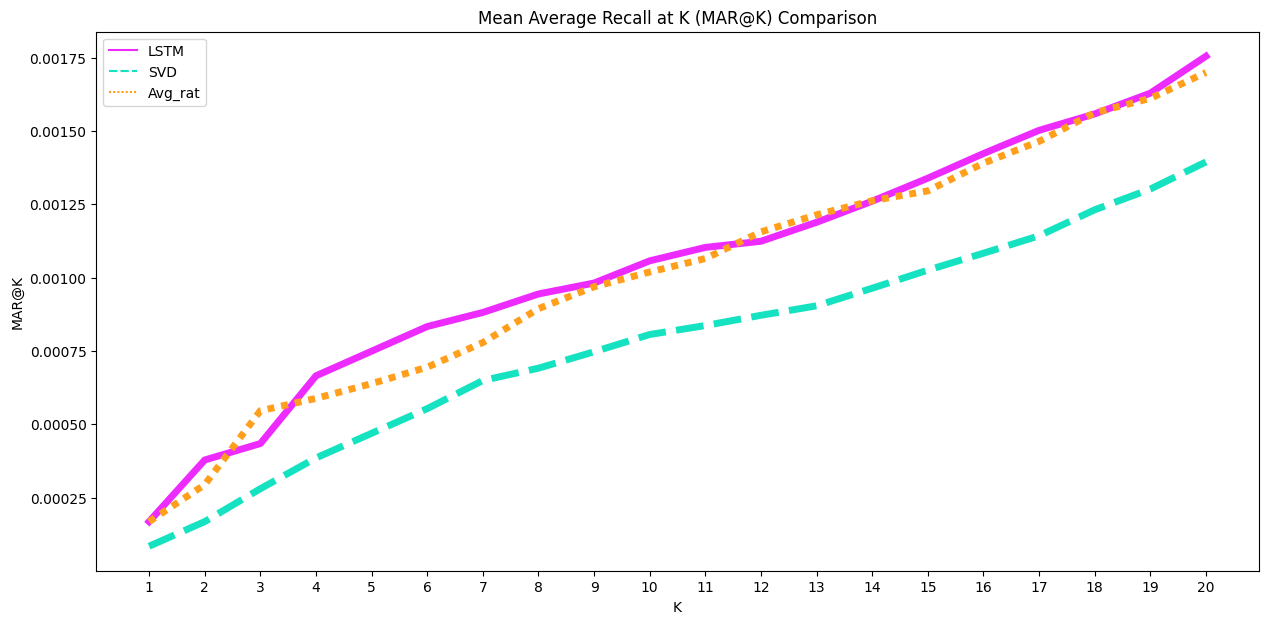

In [621]:
mark_scores = [lstm_mark, svd_mark, avg_rat_mark]
index = range(1,20+1)
names = ['LSTM', 'SVD', 'Avg_rat']

fig = plt.figure(figsize=(15, 7))
mark_plot(mark_scores, model_names=names, k_range=index)

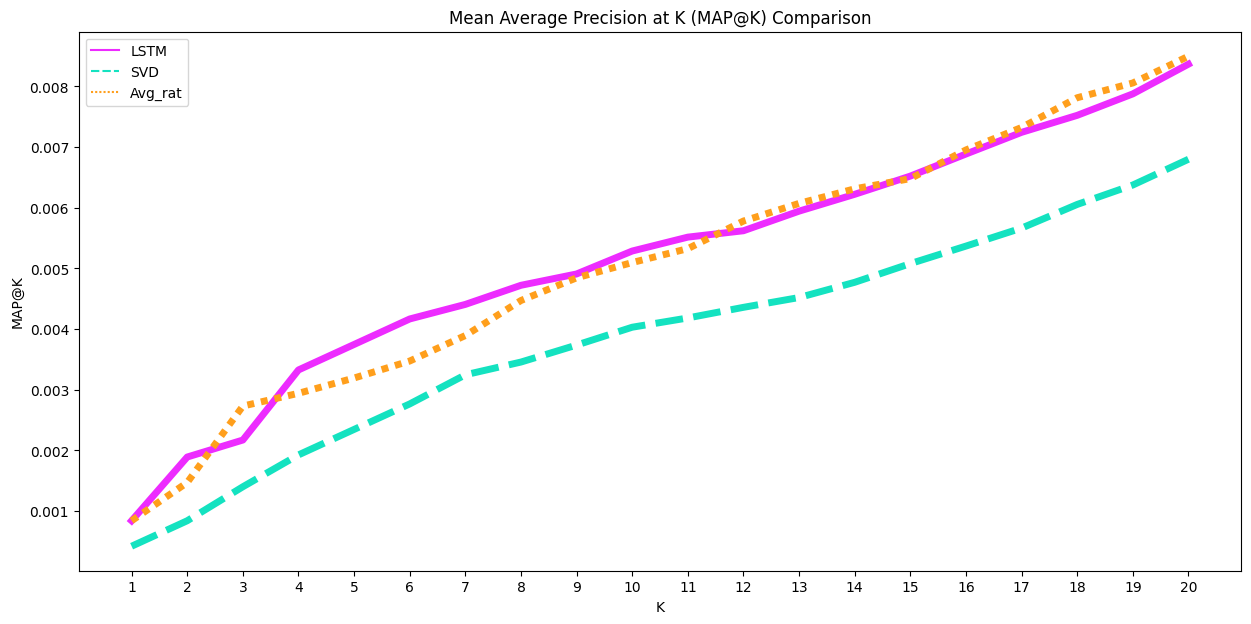

In [630]:
mapk_scores = [lstm_mapk, svd_mapk, avg_rat_mapk]
index = range(1,20+1)
names = ['LSTM', 'SVD', 'Avg_rat']

fig = plt.figure(figsize=(15, 7))
mapk_plot(mapk_scores, model_names=names, k_range=index)

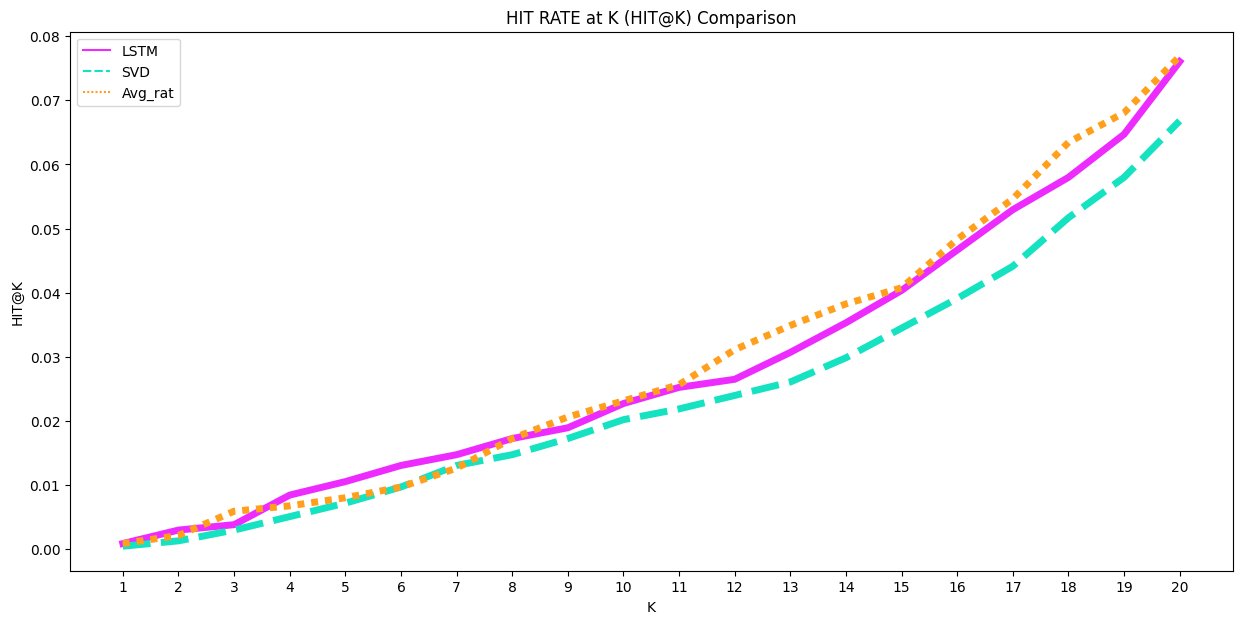

In [625]:
hit_scores = [lstm_hit, svd_hit, avg_rat_hit]
index = range(1,20+1)
names = ['LSTM', 'SVD', 'Avg_rat']

fig = plt.figure(figsize=(15, 7))
hit_plot(hit_scores, model_names=names, k_range=index)

Метрики низкие, тк рекомендательная система посторена на принципе поиска подходящих кандидатов, а не на предсказании результата.
Все 3 принципа/метода рекомендаций основаны на выборе кандидатов на основе похожести пользователей и дальнейшего предложения книг в разной зависимости. Также в тестовой выборке очень мало актуальных данных, для корректного расчета данных метрик.


Метрики качества для конкретных моделей (предсказание рейтинга с помощью СВД; предсказание класса рейтинга с помощью РНН) оцениваются значениями РМСЕ. Да, они далеки от приемлемых, но небольшое количество данных является ограничивающим фактором.

Для улучшения метрик необходимо больше данных для качественного подбора кандидатов (например, на основании жанров выбор кандидатов будет лучше, тк не будут предлагаться книги с высоким рейтингом, но совсем не интересные пользователю)